#### Importando bibliotecas

In [1]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

#### Funções necessárias para armazenar os dados e rodar o modelo

In [2]:
# Funções para carregar as imagens já pré-processadas e calcular os labels
def calculate_label(image, threshold=0.05):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(np.fliplr(data_right))
                patient_data["mask_right"].append(np.fliplr(data_msk_right))
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    print(f"Paciente {patient_id} carregado com sucesso.")
    total_recortes = len(patient_data["labels_left"]) + len(patient_data["labels_right"])
    print(f"Total de recortes: {total_recortes}")
    return patient_data

In [3]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

def augment_image(img_left, img_right, mask_left, mask_right):
    """
    Gera 7 variações (exceto a imagem original) aplicando:
    - rotação 180°
    - flip vertical
    - troca de lado
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    results_left = []
    masks_left = []
    results_right = []
    masks_right = []
    
    # Todas as combinações possíveis, exceto a (False, False, False)
    for rotate in [False, True]:
        for flip in [False, True]:
            for swap in [False, True]:
                if not (rotate or flip or swap):  # pula a imagem padrão
                    continue

                l_img = img_left.copy()
                r_img = img_right.copy()
                l_mask = mask_left.copy()
                r_mask = mask_right.copy()

                if rotate:
                    l_img = rotate_180(l_img)
                    r_img = rotate_180(r_img)
                    l_mask = rotate_180(l_mask)
                    r_mask = rotate_180(r_mask)

                if flip:
                    l_img = flip_vertical(l_img)
                    r_img = flip_vertical(r_img)
                    l_mask = flip_vertical(l_mask)
                    r_mask = flip_vertical(r_mask)

                if swap:
                    l_img, r_img = r_img, l_img
                    l_mask, r_mask = r_mask, l_mask

                results_left.append(l_img)
                masks_left.append(l_mask)
                results_right.append(r_img)
                masks_right.append(r_mask)

    return results_left, results_right, masks_left, masks_right

def augment_single_image(img_left, img_right, mask_left, mask_right, rng):
    """
    Aplica uma única modificação aleatória entre:
    - rotação 180°
    - flip vertical
    - troca de lado
    - combinações entre elas
    (7 variações possíveis)
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    # Lista de todas combinações possíveis (sem a identidade)
    transformations = [
        (True, False, False),   # só rotate
        (False, True, False),   # só flip
        (False, False, True),   # só swap
        (True, True, False),    # rotate + flip
        (True, False, True),    # rotate + swap
        (False, True, True),    # flip + swap
        (True, True, True)      # rotate + flip + swap
    ]

    # Escolhe aleatoriamente uma transformação
    rotate, flip, swap = rng.choice(transformations)

    l_img = img_left.copy()
    r_img = img_right.copy()
    l_mask = mask_left.copy()
    r_mask = mask_right.copy()

    if rotate:
        l_img = rotate_180(l_img)
        r_img = rotate_180(r_img)
        l_mask = rotate_180(l_mask)
        r_mask = rotate_180(r_mask)

    if flip:
        l_img = flip_vertical(l_img)
        r_img = flip_vertical(r_img)
        l_mask = flip_vertical(l_mask)
        r_mask = flip_vertical(r_mask)

    if swap:
        l_img, r_img = r_img, l_img
        l_mask, r_mask = r_mask, l_mask

    return l_img, r_img, l_mask, r_mask

# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images, all_labels):
    selected_images = {}
    selected_labels = []
    
    for patient in patients:
        selected_images[patient] = []
        if patient in all_images:
            selected_images[patient].extend(all_images[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images, selected_labels

In [4]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training(images_left, images_right, labels_left, labels_right, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_left = {}
    balanced_images_right = {}
    balanced_labels_left = {}
    balanced_labels_right = {}
    balanced_mask_left = {}
    balanced_mask_right = {}
    balanced_index_patients = {}

    # Separar os dados por conjunto (treino, validação, teste)
    train_patients = ['sub-02A13', 'sub-03C08', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16G09', 'sub-16I12', 'sub-19F09', 'sub-19G04', 'sub-22F14', 'sub-26B09', 'sub-31F07', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-51C05', 'sub-52K04', 'sub-57D04', 'sub-59G00', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-83K08', 'sub-85I05', 'sub-86B13']
    valid_patients = ['sub-00H10', 'sub-25B08', 'sub-29D03', 'sub-34J06', 'sub-56E13', 'sub-59E09', 'sub-60G06', 'sub-79H07']
    test_patients = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

    # patients = list(set(images_left.keys()))
    # train_patients, valtest_patients = train_test_split(patients, train_size = train_size+0.01)
    # valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    print(len(train_patients) + len(valid_patients) + len(test_patients))
    
    class_1_left = {}
    class_0_left = {}
    class_1_right = {}
    class_0_right = {}
    class_1_mask_left = {}
    class_0_mask_left = {}
    class_1_mask_right = {}
    class_0_mask_right = {}
    class_1_coordinates = {}
    class_0_coordinates = {}

    for patient_id in images_left:
        class_1_labels_left = []
        class_0_labels_left = []
        class_1_labels_right = []
        class_0_labels_right = []
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        seed = hash(patient_id) % (2**32)  # Gera uma seed única por paciente
        rng = np.random.default_rng(seed)
        
        if len(labels_left[patient_id]) == 0 or len(labels_right[patient_id]) == 0:
            continue
        
        if patient_id in test_patients:
            balanced_images_left[patient_id] = images_left[patient_id]
            balanced_images_right[patient_id] = images_right[patient_id]
            balanced_labels_left[patient_id] = labels_left[patient_id]
            balanced_labels_right[patient_id] = labels_right[patient_id]
            balanced_mask_left[patient_id] = mask_left[patient_id]
            balanced_mask_right[patient_id] = mask_right[patient_id]
            continue
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        index = 0
        for label in labels_left[patient_id]:
            image_left = (images_left[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels_left.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_mask_left[patient_id].append(mask_image_left)
            else:
                class_0_labels_left.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_mask_left[patient_id].append(mask_image_left)
        
        index = 0
        for label in labels_right[patient_id]:
            image_right = (images_right[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels_right.append(label)
                class_1_right[patient_id].append(image_right)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels_right.append(label)
                class_0_right[patient_id].append(image_right)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels_left) + len(class_1_labels_right)
        class_0_count = len(class_0_labels_left) + len(class_0_labels_right)
        print(f"Paciente {patient_id}: Total de pares de recortes com label 0: {class_0_count}")

        # Fazer Uppersampling da classe minoritária (label 1) para igualar ao número de exemplos da classe 0
        print(f"Paciente {patient_id}: Total de patches classe 1 antes do uppersampling: {class_1_count}")
        
        # Se a classe 1 for menor, aplicamos data augmentation
        if class_1_count < class_0_count:
            augmented_images_left = []
            augmented_images_right = []
            augmented_masks_left = []
            augmented_masks_right = []

            for idx, elem in enumerate(class_1_left[patient_id]):
                imgs_left_aug, imgs_right_aug, masks_left_aug, masks_right_aug = augment_image(class_0_left[patient_id][idx], class_0_right[patient_id][idx], class_0_mask_left[patient_id][idx], class_0_mask_right[patient_id][idx])
            
                augmented_images_left.extend(imgs_left_aug)
                augmented_images_right.extend(imgs_right_aug)
                augmented_masks_left.extend(masks_left_aug)
                augmented_masks_right.extend(masks_right_aug)

            # Adiciona os dados aumentados
            class_1_left[patient_id].extend(augmented_images_left)
            class_1_right[patient_id].extend(augmented_images_right)
            class_1_mask_left[patient_id].extend(augmented_masks_left)
            class_1_mask_right[patient_id].extend(augmented_masks_right)
            class_1_labels_left.extend([1] * (len(class_1_labels_left)*7))
            class_1_labels_right.extend([1] * (len(class_1_labels_right)*7))
            
        class_1_count = len(class_1_labels_left) + len(class_1_labels_right)
        print(f"Paciente {patient_id}: Total de patches classe 1 depois do uppersampling: {class_1_count}")
        
        augmented_class_0_left = []
        augmented_class_0_right = []
        augmented_class_0_mask_left = []
        augmented_class_0_mask_right = []

        i=0
        for img_left, img_right, mask_l, mask_r in zip(class_0_left[patient_id], class_0_right[patient_id], class_0_mask_left[patient_id], class_0_mask_right[patient_id]):
            # Decide aleatoriamente se vai aplicar augmentação
            seed = (hash(patient_id)+i) % (2**32)  # Gera uma seed única por paciente
            rng2 = np.random.default_rng(seed)
            if rng2.choice(2, 1, replace=False) < 1:
                aug_l, aug_r, aug_mask_l, aug_mask_r = augment_single_image(img_left, img_right, mask_l, mask_r, rng)
                augmented_class_0_left.append(aug_l)
                augmented_class_0_right.append(aug_r)
                augmented_class_0_mask_left.append(aug_mask_l)
                augmented_class_0_mask_right.append(aug_mask_r)
            else:
                # Mantém a original
                augmented_class_0_left.append(img_left)
                augmented_class_0_right.append(img_right)
                augmented_class_0_mask_left.append(mask_l)
                augmented_class_0_mask_right.append(mask_r)
            i+=1

        # Atualiza as listas da classe 0 com as versões modificadas
        class_0_left[patient_id] = augmented_class_0_left
        class_0_right[patient_id] = augmented_class_0_right
        class_0_mask_left[patient_id] = augmented_class_0_mask_left
        class_0_mask_right[patient_id] = augmented_class_0_mask_right
        
        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        # Calcula a contagem de amostras para cada classe no conjunto 'left'
        class_0_count_left = len(class_0_left[patient_id])
        class_1_count_left = len(class_1_left[patient_id])

        if class_0_count_left > class_1_count_left:
            # Caso 1.1: Classe 0 é majoritária no conjunto 'left', então fazemos undersampling dela
            print(f"Lado Esquerdo: Undersampling da Classe 0 de {class_0_count_left} para {class_1_count_left} amostras.")
            
            # Seleciona índices aleatórios da classe 0 para igualar à quantidade da classe 1
            sampled_indices = rng.choice(class_0_count_left, class_1_count_left, replace=False)
            
            # Cria novas listas com os dados amostrados
            sampled_images = [class_0_left[patient_id][i] for i in sampled_indices]
            sampled_masks = [class_0_mask_left[patient_id][i] for i in sampled_indices]
            
            # Atualiza as estruturas de dados originais com os dados amostrados
            class_0_left[patient_id] = sampled_images
            class_0_mask_left[patient_id] = sampled_masks
        else:
            # Caso 1.2: Classe 1 é majoritária (ou igual), então fazemos undersampling dela
            print(f"Lado Esquerdo: Undersampling da Classe 1 de {class_1_count_left} para {class_0_count_left} amostras.")
            
            # Seleciona índices aleatórios da classe 1 para igualar à quantidade da classe 0
            sampled_indices = rng.choice(class_1_count_left, class_0_count_left, replace=False)

            # Cria novas listas com os dados amostrados
            sampled_images = [class_1_left[patient_id][i] for i in sampled_indices]
            sampled_masks = [class_1_mask_left[patient_id][i] for i in sampled_indices]

            # Atualiza as estruturas de dados originais com os dados amostrados
            class_1_left[patient_id] = sampled_images
            class_1_mask_left[patient_id] = sampled_masks

        class_0_labels_left = [0] * len(class_0_left[patient_id])
        class_1_labels_left = [1] * len(class_1_left[patient_id])

        # Calcula a contagem de amostras para cada classe no conjunto 'right'
        class_0_count_right = len(class_0_right[patient_id])
        class_1_count_right = len(class_1_right[patient_id])

        if class_0_count_right > class_1_count_right:
            # Caso 2.1: Classe 0 é majoritária no conjunto 'right', então fazemos undersampling dela
            print(f"Lado Direito: Undersampling da Classe 0 de {class_0_count_right} para {class_1_count_right} amostras.")

            # Seleciona índices aleatórios da classe 0 para igualar à quantidade da classe 1
            sampled_indices = rng.choice(class_0_count_right, class_1_count_right, replace=False)

            # Cria novas listas com os dados amostrados
            sampled_images = [class_0_right[patient_id][i] for i in sampled_indices]
            sampled_masks = [class_0_mask_right[patient_id][i] for i in sampled_indices]
            
            # Atualiza as estruturas de dados originais com os dados amostrados
            class_0_right[patient_id] = sampled_images
            class_0_mask_right[patient_id] = sampled_masks
        else:
            # Caso 2.2: Classe 1 é majoritária (ou igual), então fazemos undersampling dela
            print(f"Lado Direito: Undersampling da Classe 1 de {class_1_count_right} para {class_0_count_right} amostras.")

            # Seleciona índices aleatórios da classe 1 para igualar à quantidade da classe 0
            sampled_indices = rng.choice(class_1_count_right, class_0_count_right, replace=False)

            # Cria novas listas com os dados amostrados
            sampled_images = [class_1_right[patient_id][i] for i in sampled_indices]
            sampled_masks = [class_1_mask_right[patient_id][i] for i in sampled_indices]
            
            # Atualiza as estruturas de dados originais com os dados amostrados
            class_1_right[patient_id] = sampled_images
            class_1_mask_right[patient_id] = sampled_masks

        class_0_labels_right = [0] * len(class_0_right[patient_id])
        class_1_labels_right = [1] * len(class_1_right[patient_id])

        print(len(class_1_left[patient_id]))
        print(len(class_1_right[patient_id]))
        print(len(class_1_labels_left) + len(class_1_labels_right))
        
        
        balanced_images_left[patient_id] = class_1_left[patient_id][:] + class_0_left[patient_id][:]
        balanced_images_right[patient_id] = class_1_right[patient_id][:] + class_0_right[patient_id][:]
        balanced_labels_left[patient_id] = class_1_labels_left + class_0_labels_left
        balanced_labels_right[patient_id] = class_1_labels_right + class_0_labels_right
        balanced_mask_left[patient_id] = class_1_mask_left[patient_id][:] + class_0_mask_left[patient_id][:]
        balanced_mask_right[patient_id] = class_1_mask_right[patient_id][:] + class_0_mask_right[patient_id][:]
        
        balanced_index = rng.choice(range(len(balanced_images_left[patient_id])), len(balanced_images_left[patient_id]), replace=False)            
        balanced_images_left[patient_id] = [balanced_images_left[patient_id][i] for i in balanced_index]
        balanced_labels_left[patient_id] = [balanced_labels_left[patient_id][i] for i in balanced_index]
        balanced_mask_left[patient_id] = [balanced_mask_left[patient_id][i] for i in balanced_index]

        balanced_index = rng.choice(range(len(balanced_images_right[patient_id])), len(balanced_images_right[patient_id]), replace=False)            
        balanced_images_right[patient_id] = [balanced_images_right[patient_id][i] for i in balanced_index]
        balanced_labels_right[patient_id] = [balanced_labels_right[patient_id][i] for i in balanced_index]
        balanced_mask_right[patient_id] = [balanced_mask_right[patient_id][i] for i in balanced_index]
        balanced_index_patients[patient_id] = balanced_index
        
        class_1_count = len(class_1_labels_left) + len(class_1_labels_right)
        class_0_count = len(class_0_labels_left) + len(class_0_labels_right)
        print(f"Paciente {patient_id}: Total de patches no final: {class_1_count+class_0_count}")

    X_train_left, y_train_left = select_by_patients(train_patients, balanced_images_left, balanced_labels_left)
    X_val_left, y_val_left = select_by_patients(valid_patients, balanced_images_left, balanced_labels_left)
    X_test_left, y_test_left = select_by_patients(test_patients, balanced_images_left, balanced_labels_left)
    
    X_train_right, y_train_right = select_by_patients(train_patients, balanced_images_right, balanced_labels_right)
    X_val_right, y_val_right = select_by_patients(valid_patients, balanced_images_right, balanced_labels_right)
    X_test_right, y_test_right = select_by_patients(test_patients, balanced_images_right, balanced_labels_right)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train_left.count(1) + y_train_right.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train_left.count(0) + y_train_right.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val_left.count(1) + y_val_right.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val_left.count(0) + y_val_right.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test_left.count(1) + y_test_right.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test_left.count(0) + y_test_right.count(0)}")
    
    return X_train_left, X_train_right, X_val_left, X_val_right, X_test_left, X_test_right, np.array(y_train_left), np.array(y_train_right), np.array(y_val_left), np.array(y_val_right), np.array(y_test_left), np.array(y_test_right), train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients


In [5]:
def get_augmenter(input_shape, seed=42):
    """Cria uma camada de aumento de dados que aplica transformações aleatórias."""
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.RandomFlip("horizontal_and_vertical", seed=seed),
        layers.RandomRotation(0.2, seed=seed),
        layers.RandomContrast(0.2, seed=seed),
        layers.GaussianNoise(0.1, seed=seed)
    ], name="augmenter")

def nt_xent_loss(projections, temperature=0.1):
    """Calcula a perda NT-Xent (Normalized Temperature-scaled Cross-Entropy)."""
    batch_size = tf.shape(projections)[0] // 2
    projections = tf.math.l2_normalize(projections, axis=1)
    similarity_matrix = tf.matmul(projections, projections, transpose_b=True)
    labels = tf.roll(tf.eye(batch_size * 2), shift=batch_size, axis=1)
    loss = tf.keras.losses.categorical_crossentropy(
        y_true=labels,
        y_pred=tf.nn.softmax(similarity_matrix / temperature, axis=1),
        from_logits=False,
    )
    return tf.reduce_mean(loss)

class SSCLModel(Model):
    """Modelo Keras customizado para o pré-treinamento auto-supervisionado."""
    def __init__(self, encoder, projection_head, augmenter):
        super().__init__()
        self.encoder = encoder
        self.projection_head = projection_head
        self.augmenter = augmenter
    
    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer

    def train_step(self, images):
        augmented_view_1 = self.augmenter(images)
        augmented_view_2 = self.augmenter(images)
        all_views = tf.concat([augmented_view_1, augmented_view_2], axis=0)
        with tf.GradientTape() as tape:
            embeddings = self.encoder(all_views)
            projections = self.projection_head(embeddings)
            loss = nt_xent_loss(projections)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

    def test_step(self, images):
        augmented_view_1 = self.augmenter(images)
        augmented_view_2 = self.augmenter(images)
        all_views = tf.concat([augmented_view_1, augmented_view_2], axis=0)
        embeddings = self.encoder(all_views)
        projections = self.projection_head(embeddings)
        loss = nt_xent_loss(projections)
        return {"loss": loss}

def build_encoder(input_shape):
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(8, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Flatten()
    ], name="encoder")

def build_projection_head(embedding_dim=128):
    return models.Sequential([
        layers.Dense(embedding_dim, activation='relu'),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # Normalização L2
    ], name="projection_head")

def build_classifier_model(encoder, num_classes):
    encoder.trainable = False # Congela o encoder
    return models.Sequential([
        Input(shape=encoder.input_shape[1:]),
        encoder,
        layers.Dense(num_classes, activation='softmax')
    ])

In [26]:
# Funções de plot do modelo
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss') 
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Graphic')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


#### Rodando função de Pré-Processamento

In [8]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Contralateral"

# Lista de IDs dos pacientes
patient_ids = os.listdir(folder)

X_left, X_right, y_left, y_right, mask_left, mask_right = {}, {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y_left[patient_id] = patient_data["labels_left"]
        y_right[patient_id] = patient_data["labels_right"]

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 2262
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 2290
Paciente sub-03C08 carregado com sucesso.
Total de recortes: 2012
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 2226
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 2360
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 2512
Paciente sub-16G09 carregado com sucesso.
Total de recortes: 2256
Paciente sub-16I12 carregado com sucesso.
Total de recortes: 2412
Paciente sub-19F09 carregado com sucesso.
Total de recortes: 2440
Paciente sub-19G04 carregado com sucesso.
Total de recortes: 2260
Paciente sub-22F14 carregado com sucesso.
Total de recortes: 2296
Paciente sub-25B08 carregado com sucesso.
Total de recortes: 2454
Paciente sub-26B09 carregado com sucesso.
Total de recortes: 2358
Paciente sub-29D03 carregado com sucesso.
Total de recortes: 2204
Paciente sub-31F07 carregado com sucesso.
Total de recortes: 2250
Paciente s

In [9]:
# Preparar dados para treino, validação e teste
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_left_balanced, y_train_right_balanced, y_valid_left_balanced, y_valid_right_balanced, y_test_left, y_test_right, train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients = prepare_data_for_training(X_left, X_right, y_left, y_right, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)
train_balanced = normalize_minmax(np.concatenate((np.array([elemento for lista in train_left_balanced.values() for elemento in lista]), np.array([elemento for lista in train_right_balanced.values() for elemento in lista])), axis=0))
valid_balanced = normalize_minmax(np.concatenate((np.array([elemento for lista in valid_left_balanced.values() for elemento in lista]), np.array([elemento for lista in valid_right_balanced.values() for elemento in lista])), axis=0))
test = normalize_minmax(np.concatenate((np.array([elemento for lista in test_left.values() for elemento in lista]), np.array([elemento for lista in test_right.values() for elemento in lista])), axis=0))

41
Paciente sub-00H10: Total de pares de recortes com label 0: 2251
Paciente sub-00H10: Total de patches classe 1 antes do uppersampling: 11
Paciente sub-00H10: Total de patches classe 1 depois do uppersampling: 88
Lado Esquerdo: Undersampling da Classe 0 de 1120 para 0 amostras.
Lado Direito: Undersampling da Classe 0 de 1120 para 11 amostras.
0
11
11
Paciente sub-00H10: Total de patches no final: 22
Paciente sub-02A13: Total de pares de recortes com label 0: 2197
Paciente sub-02A13: Total de patches classe 1 antes do uppersampling: 93
Paciente sub-02A13: Total de patches classe 1 depois do uppersampling: 744
Lado Esquerdo: Undersampling da Classe 0 de 1052 para 0 amostras.
Lado Direito: Undersampling da Classe 0 de 1052 para 93 amostras.
0
93
93
Paciente sub-02A13: Total de patches no final: 186
Paciente sub-03C08: Total de pares de recortes com label 0: 1971
Paciente sub-03C08: Total de patches classe 1 antes do uppersampling: 41
Paciente sub-03C08: Total de patches classe 1 depois 

In [10]:
# Adiciono camada de cor
train_balanced = np.expand_dims(train_balanced, axis=-1)
valid_balanced = np.expand_dims(valid_balanced, axis=-1)
test = np.expand_dims(test, axis=-1)


In [24]:
print("\n--- Iniciando Etapa 1: Pré-treinamento Auto-Supervisionado ---")
all_images_list = [img for p_id in patient_ids for img in X_left.get(p_id, []) + X_right.get(p_id, [])]
pretrain_data = normalize_minmax(np.array(all_images_list))
pretrain_data = np.expand_dims(pretrain_data, axis=-1)
print(f"Total de imagens para pré-treinamento: {len(pretrain_data)}")

input_shape = pretrain_data[0].shape
encoder = build_encoder(input_shape)
projection_head = build_projection_head(embedding_dim=128)
augmenter = get_augmenter(input_shape)


--- Iniciando Etapa 1: Pré-treinamento Auto-Supervisionado ---
Total de imagens para pré-treinamento: 94192


In [25]:
# Treinar o modelo contrastivo de pré-treinamento
print("\n--- Iniciando Pré-treinamento Contrastivo ---")

# Salvar a melhor epoca
sscl_model = SSCLModel(encoder, projection_head, augmenter)
sscl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history_sscl = sscl_model.fit(pretrain_data, epochs=100, batch_size=128)
encoder.save_weights('sscl_encoder_pretrained.weights.h5')
print("Pesos do encoder pré-treinado salvos com sucesso!")


--- Iniciando Pré-treinamento Contrastivo ---
Epoch 1/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - loss: 1.5586
Epoch 2/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 51s 70ms/step - loss: 1.1612
Epoch 3/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 51s 69ms/step - loss: 1.0336
Epoch 4/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 51s 69ms/step - loss: 0.9986
Epoch 5/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 52s 71ms/step - loss: 0.9684
Epoch 6/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - loss: 0.9473
Epoch 7/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - loss: 0.9334
Epoch 8/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - loss: 0.9139
Epoch 9/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 51s 69ms/step - loss: 0.9275
Epoch 10/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 51s 69ms/step - loss: 0.9277
Epoch 11/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 52s 71ms/step - loss: 0.8993
Epoch 12/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 51s 69ms/step - loss: 0.8903
Epoch 13/100
736/736 ━━━━━━━━━━━━━━━━━━━━ 51s 69ms/step - loss: 0.8910
Epoch 14/100
736/736 ━━━━━━━━━━━━━━━━━━

In [27]:
y_train_one_hot = tf.keras.utils.to_categorical(np.concatenate((y_train_left_balanced, y_train_right_balanced),axis=0), num_classes=2)
y_val_one_hot = tf.keras.utils.to_categorical(np.concatenate((y_valid_left_balanced, y_valid_right_balanced),axis=0), num_classes=2)

finetune_encoder = build_encoder(input_shape)
finetune_encoder.load_weights('sscl_encoder_pretrained.weights.h5')

classifier_model = build_classifier_model(finetune_encoder, num_classes=2)
classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Precision(name="Precision"), metrics.Recall(name="Recall")]
)

history_classifier = classifier_model.fit(
    train_balanced, y_train_one_hot,
    validation_data=(valid_balanced, y_val_one_hot),
    epochs=50,
    batch_size=64
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - Precision: 0.6150 - Recall: 0.6150 - accuracy: 0.6150 - loss: 2.1134 - val_Precision: 0.7330 - val_Recall: 0.7330 - val_accuracy: 0.7330 - val_loss: 0.7992
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - Precision: 0.6684 - Recall: 0.6684 - accuracy: 0.6684 - loss: 1.0708 - val_Precision: 0.7420 - val_Recall: 0.7420 - val_accuracy: 0.7420 - val_loss: 0.6123
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - Precision: 0.6751 - Recall: 0.6751 - accuracy: 0.6751 - loss: 0.8074 - val_Precision: 0.7559 - val_Recall: 0.7559 - val_accuracy: 0.7559 - val_loss: 0.6278
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - Precision: 0.6779 - Recall: 0.6779 - accuracy: 0.6779 - loss: 0.7526 - val_Precision: 0.6510 - val_Recall: 0.6510 - val_accuracy: 0.6510 - val_loss: 0.7836
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - Precision: 0.6689 - Recall: 0.6689 - accuracy: 0.6689 - loss: 0.7617 - val_Precision: 0.7415 - val_Re

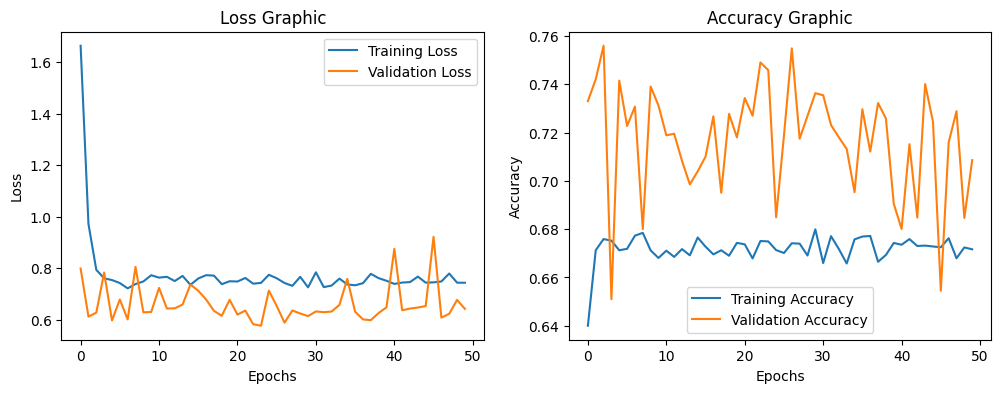

In [29]:
# Plotar o histórico do treinamento
plot_training_history(history_classifier)


--- Avaliando o modelo final no conjunto de teste ---
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

AUC da Curva Precision-Recall: 0.1913


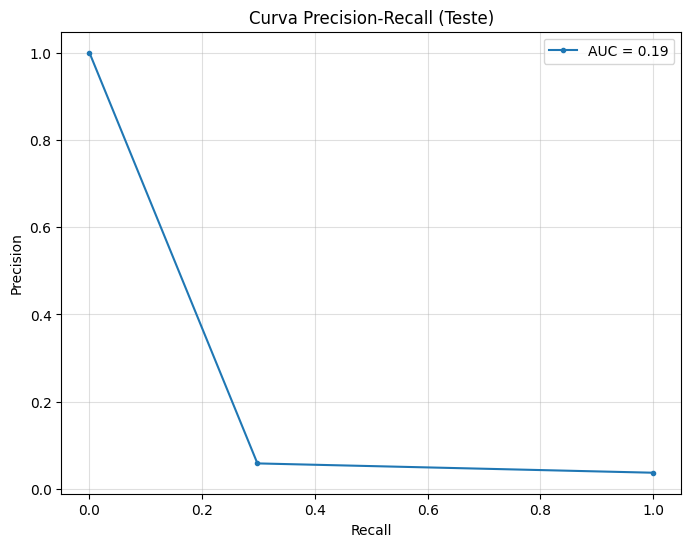

In [31]:
print("\n--- Avaliando o modelo final no conjunto de teste ---")
# Fazer predições no conjunto de validação e teste
y_pred_valid = classifier_model.predict(valid_balanced)
y_pred_test = classifier_model.predict(test)

# Para obter os labels (0 ou 1), usamos argmax
y_pred_valid = np.argmax(y_pred_valid, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Calcular e plotar a Curva Precision-Recall
precision, recall, _ = precision_recall_curve(np.concatenate((y_test_left, y_test_right), axis=0), y_pred_test)
auc_pr = auc(recall, precision)

print(f"\nAUC da Curva Precision-Recall: {auc_pr:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (Teste)')
plt.legend(loc='best')
plt.grid(alpha=0.4)
plt.show()

In [32]:
# Gerar o relatório de classificação
print("Validação:")
print(classification_report(np.concatenate((y_valid_left_balanced, y_valid_right_balanced), axis=0), y_pred_valid, target_names=['Classe Saudável', 'Classe Displasia']))
print("\n#########################################################\n")
print("Teste:")
print(classification_report(np.concatenate((y_test_left, y_test_right), axis=0), y_pred_test, target_names=['Classe Saudável', 'Classe Displasia']))

Validação:
                  precision    recall  f1-score   support

 Classe Saudável       0.69      0.76      0.72      6367
Classe Displasia       0.73      0.65      0.69      6367

        accuracy                           0.71     12734
       macro avg       0.71      0.71      0.71     12734
    weighted avg       0.71      0.71      0.71     12734


#########################################################

Teste:
                  precision    recall  f1-score   support

 Classe Saudável       0.97      0.82      0.88      9057
Classe Displasia       0.06      0.30      0.10       349

        accuracy                           0.80      9406
       macro avg       0.51      0.56      0.49      9406
    weighted avg       0.93      0.80      0.86      9406



Validação:


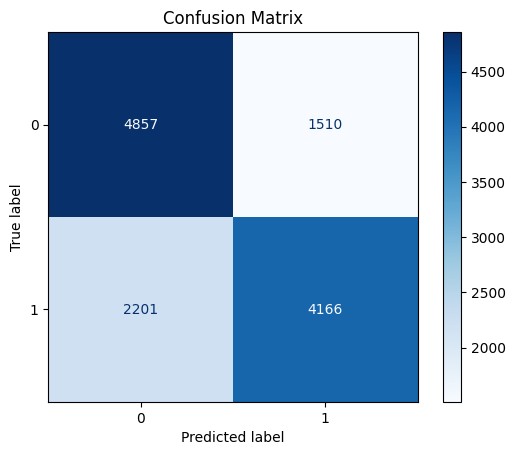

Teste:


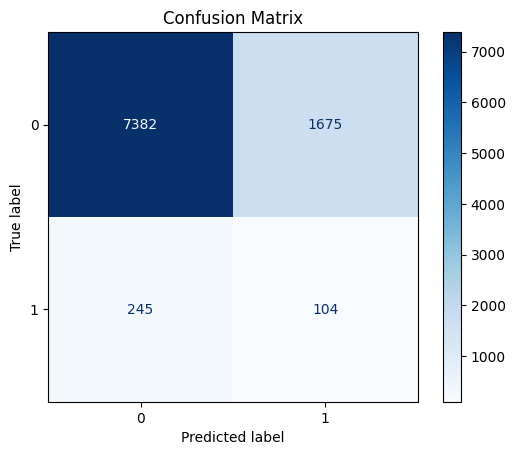

In [33]:
# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(np.concatenate((y_valid_left_balanced, y_valid_right_balanced), axis=0), y_pred_valid)
print("Teste:")
plot_confusion_matrix(np.concatenate((y_test_left, y_test_right), axis=0), y_pred_test)

##### Rodando processos de Pós-Processamento

In [ ]:
def load_patient_data_per_slice(folder, patient_id): # carregar dados de teste, mantendo os dados de cada fatia em um vetor
    patient_path = os.path.join(folder, patient_id)  # folder/patient/
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    labels_total = []
    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])  # folder/patient/left
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)  # folder/patient/left/slice_
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)
        
        slice_left_img = []
        slice_right_img = []
        slice_left_mask = []
        slice_right_mask = []
        slice_left_labels = []
        slice_right_labels = []

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()

            if len(data_left) > 0 or len(data_msk_left) > 0:
                slice_left_img.append(data_left)
                slice_left_mask.append(data_msk_left)
                slice_left_labels.append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()

            if len(data_right) > 0 or len(data_msk_right) > 0:
                slice_right_img.append(data_right)
                slice_right_mask.append(data_msk_right)
                slice_right_labels.append(calculate_label(data_msk_right))

        patient_data["images_left"].append(slice_left_img)
        patient_data["mask_left"].append(slice_left_mask)
        patient_data["labels_left"].append(slice_left_labels)

        patient_data["images_right"].append(slice_right_img)
        patient_data["mask_right"].append(slice_right_mask)
        patient_data["labels_right"].append(slice_right_labels)

        labels_pair = []
        for label_left, label_right in zip(slice_left_labels, slice_right_labels):
            if label_left == 0 and label_right == 0:
                labels_pair.append(0)
            else:
                labels_pair.append(1)
        labels_total.append(labels_pair)

    patient_data["labels_pair"] = labels_total

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_total)}")
    return patient_data, labels_total

def test_labels_near(predictions): # pós-processamento
    new_pred = copy.deepcopy(predictions)
    previous_pos = 0
    actual_pos = 0
    next_pos = 0

    for i in range(1, len(predictions) - 1):

        # testa posições "perto", mas tá errado pela ordem dos recortes dentro da fatia
        for j in range(1, len(predictions[i])-1):
            if predictions[i][j] == 0 and predictions[i][j-1] == 1 and predictions[i][j+1] == 1:
                new_pred[i][j+1] = 0
                new_pred[i][j-1] = 0
                print(f"ANTES unit: {predictions[i]}")
                print(f"DEPOIS: {new_pred[i]}\n")

        # testa 3 fatias sequenciais
        previous_pos = np.count_nonzero(predictions[i - 1])
        actual_pos = np.count_nonzero(predictions[i])
        next_pos = np.count_nonzero(predictions[i + 1])

        if (previous_pos == 0 and actual_pos >= 1 and next_pos == 0):
            new_pred[i] = np.array([0 for j in range(len(predictions[i]))])
            print(f"ANTES whole: {predictions[i]}")
            print(f"DEPOIS: {new_pred[i]}\n")

    return new_pred

In [ ]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
test_patient_ids = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

X_slices_left, X_slices_right, y_slices, mask_slices_left, mask_slices_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in test_patient_ids:
    # Carrega os dados do paciente
    patient_data_test, labels_pair_test = load_patient_data_per_slice(folder, patient_id)
    
    if patient_data_test is not None:
        X_slices_left[patient_id] = patient_data_test["images_left"]
        X_slices_right[patient_id] = patient_data_test["images_right"]
        mask_slices_left[patient_id] = patient_data_test["mask_left"]
        mask_slices_right[patient_id] = patient_data_test["mask_right"]
        y_slices[patient_id] = labels_pair_test

In [ ]:
# Normalização e tratamento de dimensões do dado de teste
test_single_left = {}
test_single_right = {}

for id in test_patient_ids:
    test_single_left[id] = []
    test_single_right[id] = []

    for i in range(0, len(X_slices_left[id])):
        test_single_left[id].append([])
        test_single_right[id].append([])

        for j in range(0, len(X_slices_left[id][i])):
            # print(f"Dados do paciente {id} da fatia {i} do dado {j} esquerdo")
            test_single_left[id][i].append(normalize_minmax(np.array(X_slices_left[id][i][j]))) # normaliza as imagens
            test_single_right[id][i].append(normalize_minmax(np.array(X_slices_right[id][i][j])))

        test_single_left[id][i] = np.expand_dims(test_single_left[id][i], axis=-1) # expande eixo pra passar rede pra predict
        test_single_right[id][i] = np.expand_dims(test_single_right[id][i], axis=-1)

In [ ]:
# Construir e compilar o modelo CNN
input_shape = (test_single_left[test_patient_ids[0]][0][0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

y_test_slices_pred = {}

for patient in test_patient_ids:
    print(f"paciente {patient}")
    y_test_slices_pred[patient] = []

    for i in range(0, len(X_slices_left[patient])):
        print(f"fatia {i}")
        left = test_single_left[patient][i]
        right = test_single_right[patient][i]
        y_test_slices_pred[patient].append((siamese_model.predict([left, right]) > 0.5).astype(int).flatten())

#### Comparando resultados sem e com Pós-Processamento

In [ ]:
# labels certos -> y_slices
# predição não processada -> y_test_slices_pred
# predição processada -> processed labels

processed_labels = {}

# crio um novo vetor com os labels processados
for patient_name in test_patient_ids:
    processed_labels[patient_name] = test_labels_near(y_test_slices_pred[patient_name])


In [ ]:
labels_pred_processed = list(itertools.chain(*list(itertools.chain(*processed_labels.values()))))

# Gerar a matriz de confusão
print("RESULTADO ORIGINAL:")
plot_confusion_matrix(y_test, y_pred_test)
print("\n#########################################################\n")
print("PÓS PROCESSADO:")
plot_confusion_matrix(y_test, labels_pred_processed)

# print(labels_true)
# print(labels_pred_raw)
# print(labels_pred_processed)

# print(np.count_nonzero(labels_true))
# print(np.count_nonzero(labels_pred_raw))
# print(np.count_nonzero(labels_pred_processed))

In [ ]:
print("Teste") 
print(classification_report(y_test, labels_pred_processed)) 

#### Plotando PDFs para comparação dos resultados e análise das classificações

In [ ]:
# Função para adicionar borda ao patch com a cor da classificação
def add_border(image, color, thickness=3):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    bordered_image = cv2.copyMakeBorder(image_rgb, thickness, thickness, thickness, thickness, cv2.BORDER_CONSTANT, value=color)
    return bordered_image

def enhance_contrast(img, factor=1.1):
    img = img.astype(np.float32)
    img = img * factor
    return np.clip(img, 0, 255).astype(np.uint8)

# Função para carregar imagens no formato NIfTI (.nii.gz)
def load_nii_slice(patient_id, slice_index, base_path):
    file_path = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.nii.gz")
    if os.path.exists(file_path):
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()
        return img_data
    return None

# Função para carregar coordenadas de arquivos .txt
def load_coordinates(patient_id, slice_index, base_path):
    coord_file = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.txt")
    if os.path.exists(coord_file):
        with open(coord_file, "r") as file:
            coordinates = [tuple(map(int, line.strip().split(","))) for line in file]
        return coordinates
    return []

# Função para reconstruir a imagem e sobrepor o grid
def build_image_with_grid(patient_id, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)
    
    if img is None or mask is None or not coordinates:
        return None, None, index

    img = enhance_contrast(img)
    mask = enhance_contrast(mask)

    reconstructed_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    
    half = len(coordinates) // 2
    classifications = []

    for i in range(half):
        true = labels_true[i + index]
        pred = labels_pred[i + index]
        if pred == true:
            classif = "TP" if pred == 1 else "TN"
        else:
            classif = "FP" if pred == 1 else "FN"
        classifications.append(classif)
    
    # Repetir a classificação para o lado direito
    classifications.extend(classifications)

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        classif = classifications[i]

        patch_img = img[y1+3:y2-3, x1+3:x2-3]
        patch_mask = mask[y1+3:y2-3, x1+3:x2-3]

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask, (index + half)

# Reconstrói uma fatia do paciente usando coordenadas + indexes mapeados
def build_image_with_grid_indexed(patient_id, slice_index, balanced_index_patients,
                                  labels_pred, labels_true, image_path, mask_path,
                                  coordinates_path, patch_metadata):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)

    if img is None or mask is None or not coordinates:
        return None, None

    img = enhance_contrast(img)
    mask = enhance_contrast(mask)
    
    height, width = img.shape[:2]
    reconstructed_img = np.zeros((height, width, 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((height, width, 3), dtype=np.uint8)

    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        # Identifica o global_index da coordenada
        global_index = None
        for idx, meta in patch_metadata.items():
            if meta[0] == patient_id and meta[1] == slice_index and meta[3:] == (y1, y2, x1, x2):
                global_index = idx
                break

        if global_index in balanced_index_patients:
            label_pos = balanced_index_patients.index(global_index)
            true_label = labels_true[label_pos]
            pred_label = labels_pred[label_pos]

            if pred_label == true_label:
                classif = "TP" if pred_label == 1 else "TN"
            else:
                classif = "FP" if pred_label == 1 else "FN"

            patch_img = img[y1+3:y2-3, x1+3:x2-3]
            patch_mask = mask[y1+3:y2-3, x1+3:x2-3]
        else:
            classif = "TN"
            patch_img = np.zeros((y2 - y1 - 6, x2 - x1 - 6), dtype=np.uint8)
            patch_mask = np.zeros((y2 - y1 - 6, x2 - x1 - 6), dtype=np.uint8)

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask

# Gera metadados global_index → (patient, slice, side, y1, y2, x1, x2)
def generate_patch_metadata(patients, coordinates_path):
    patch_metadata = {}
    global_index = 0
    for patient in patients:
        patient_dir = os.path.join(coordinates_path, patient)
        if not os.path.isdir(patient_dir):
            continue
        for filename in sorted(os.listdir(patient_dir)):
            if filename.endswith(".txt"):
                slice_index = int(filename.split("_")[1].split(".")[0])
                coord_file = os.path.join(patient_dir, filename)
                with open(coord_file, "r") as f:
                    coords = [tuple(map(int, line.strip().split(","))) for line in f if line.strip()]
                half = len(coords) // 2
                for i, (y1, y2, x1, x2) in enumerate(coords):
                    side = 'left' if i < half else 'right'
                    patch_metadata[global_index] = (patient, slice_index, side, y1, y2, x1, x2)
                    global_index += 1
    print(f"✅ Mapeamento gerado com {len(patch_metadata)} patches.")
    return patch_metadata


In [ ]:
def plot_patient_slices(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-42B05': 1204, 'sub-42K06': 1122, 'sub-44H05': 1213, 'sub-86G08': 1189}
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Uppersampling+Undersampling.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_test,
    labels_pred=y_pred_test,
)

In [ ]:
def plot_nifti_patient_slices_with_borders_and_masks(
    pdf_folder, patients, coordinates_path, image_path, mask_path,
    labels_true, labels_pred, balanced_index_patients
):
    os.makedirs(pdf_folder, exist_ok=True)

    patch_metadata = generate_patch_metadata(patients, coordinates_path)

    # Mapeia slices por paciente
    slices_por_paciente = {}
    for idx, (patient_id, slice_idx, _, _, _, _, _) in patch_metadata.items():
        slices_por_paciente.setdefault(patient_id, set()).add(slice_idx)

    for patient in patients:
        if patient not in slices_por_paciente:
            continue

        slice_indices = sorted(slices_por_paciente[patient])
        patient_folder = os.path.join(pdf_folder, patient)
        os.makedirs(patient_folder, exist_ok=True)
        pdf_filename = os.path.join(patient_folder, f"Paciente_{patient}.pdf")

        with PdfPages(pdf_filename) as pdf:
            for slice_idx in slice_indices:
                img_reconstructed, mask_reconstructed = build_image_with_grid_indexed(
                    patient_id=patient,
                    slice_index=slice_idx,
                    balanced_index_patients=balanced_index_patients,
                    labels_pred=labels_pred,
                    labels_true=labels_true,
                    image_path=image_path,
                    mask_path=mask_path,
                    coordinates_path=coordinates_path,
                    patch_metadata=patch_metadata
                )

                if img_reconstructed is None or mask_reconstructed is None:
                    continue

                fig, axs = plt.subplots(2, 1, figsize=(8, 12))
                axs[0].imshow(img_reconstructed)
                axs[0].set_title(f"Reconstrução com Classificação - {patient} - Slice {slice_idx:03d}")
                axs[0].axis("off")

                axs[1].imshow(mask_reconstructed)
                axs[1].set_title("Máscara Correspondente")
                axs[1].axis("off")

                pdf.savefig(fig)
                plt.close(fig)

        print(f"✅ PDF salvo: {pdf_filename}")

    print(f"\n📁 Todos os PDFs foram salvos em: {pdf_folder}")

# plot_nifti_patient_slices_with_borders_and_masks(
#     pdf_folder="Pdf_Final_NIfTI_Reconstruido",
#     patients=train_patients,
#     coordinates_path="Coordenadas_grid",
#     image_path="Fatias",
#     mask_path="Mask_Fatias",
#     labels_true=y_train_balanced,
#     labels_pred=y_pred_train,
#     balanced_index_patients=balanced_index_patients
# )

plot_nifti_patient_slices_with_borders_and_masks(
    pdf_folder="Pdf_Final_NIfTI_Reconstruido",
    patients=valid_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_valid_balanced,
    labels_pred=y_pred_valid,
    balanced_index_patients=balanced_index_patients
)

In [ ]:
def plot_patient_slices_paired(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-42B05': 1204, 'sub-42K06': 1122, 'sub-44H05': 1213, 'sub-86G08': 1189}
plot_patient_slices_paired(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Pareamento.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_test,
    labels_pred=y_pred_test,
)

In [ ]:
def plot_patient_patches_paired(pdf_filename, patients, images_left, images_right, masks_left, masks_right, labels_true, labels_pred, balanced_index_by_patients, type):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)

    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            print(f"\n🔍 Paciente: {patient}")
            indices = paired_index_dictionary[type].get(patient, [])
            print(f"📊 Número de pares: {len(indices)}")

            for i in range(len(indices)):
                colors = {"TP": (0, 255, 0), "TN": (150, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}

                # Calcula a classificação
                true_label = labels_true[index]
                pred_label = labels_pred[index]
                if pred_label == true_label:
                    classification = "TP" if pred_label == 1 else "TN"
                else:
                    classification = "FP" if pred_label == 1 else "FN"

                color = colors[classification]

                # Pega patches esquerdo e direito e máscaras pelos arrays alinhados
                patch_left = images_left[index]
                patch_right = images_right[index]
                mask_l = masks_left[index]
                mask_r = masks_right[index]

                # Aplica bordas
                bordered_patch_left = add_border(patch_left, color)
                bordered_patch_right = add_border(patch_right, color)
                bordered_mask_left = add_border(mask_l, color)
                bordered_mask_right = add_border(mask_r, color)

                # Plotagem
                fig, axs = plt.subplots(2, 2, figsize=(6, 6))
                axs[0, 0].imshow(bordered_patch_left)
                axs[0, 0].set_title("Img Esq")
                axs[0, 1].imshow(bordered_patch_right)
                axs[0, 1].set_title("Img Dir")
                axs[1, 0].imshow(bordered_mask_left)
                axs[1, 0].set_title("Mask Esq")
                axs[1, 1].imshow(bordered_mask_right)
                axs[1, 1].set_title("Mask Dir")

                for ax in axs.flat:
                    ax.axis('off')

                fig.suptitle(f"Paciente: {patient} | {classification}", fontsize=10)
                pdf.savefig(fig)
                plt.close(fig)

                index += 1

        print(f"Patches com bordas salvos em {pdf_filename}")

plot_patient_patches_paired(
    pdf_filename="Pdf_SNN/Train_Patches_SemReconstrucao_Pareamento.pdf",
    patients=train_patients,
    images_left=train_left_balanced,
    images_right=train_right_balanced,
    masks_left=mask_train_left,
    masks_right=mask_train_right,
    labels_true=y_train_balanced,
    labels_pred=y_pred_train,
    balanced_index_by_patients=paired_index_dictionary['train'],
    type = 'train'
)

plot_patient_patches_paired(
    pdf_filename="Pdf_SNN/Valid_Patches_SemReconstrucao_Pareamento.pdf",
    patients=valid_patients,
    images_left=valid_left_balanced,
    images_right=valid_right_balanced,
    masks_left=mask_valid_left,
    masks_right=mask_valid_right,
    labels_true=y_valid_balanced,
    labels_pred=y_pred_valid,
    balanced_index_by_patients=paired_index_dictionary['val'],
    type = 'val'
)
